In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import operator
import os
from datetime import datetime
from enum import Enum
from typing import Optional, TypedDict

from langchain.messages import AnyMessage, ToolMessage
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from typing_extensions import Annotated, TypedDict

In [3]:
# Tracking with MLflow
import mlflow

# Set MLflow experiment
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("Tracing Quickstart")

# Enable tracing
mlflow.langchain.autolog()

In [4]:
class Action(str, Enum):
    CREATE_CLIENT = "create_client"
    UPDATE_CLIENT = "update_client"
    CREATE_JOB = "create_job"
    UPDATE_JOB = "update_job"
    EXTRACT = "extract"

class Subject(str, Enum):
    CLIENT = "client"
    JOB = "job"

class JobStatus(str, Enum):
    PENDING = "pending"
    IN_PROGRESS = "in_progress"
    COMPLETED = "completed"

In [5]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    command: str
    object_id: Optional[str]
    action: Action
    subject: Subject
    data_fields: list[str]

In [6]:
class Client(BaseModel):
    id: str | None = Field(None, description="Unique identifier for the client")
    name: str | None = Field(None, description="Name of the customer")
    email: str | None = Field(None, description="Email of the customer")
    phone: str | None = Field(None, description="Phone of the customer")


class Job(BaseModel):
    id: str | None = Field(None, description="Unique identifier for the job")
    client_id: str | None = Field(
        None, description="Identifier of the client that owns the job"
    )
    title: str | None = Field(None, description="Title of the job")
    description: str | None = Field(None, description="Description of the job")
    location: str | None = Field(None, description="Location of the job")
    status: JobStatus | None = Field(None, description="Status of the job")
    start_date: datetime | None = Field(None, description="Start date of the job")
    end_date: datetime | None = Field(None, description="End date of the job")

In [7]:
model = ChatOpenAI(model="gpt-4o", streaming=False)

In [8]:
# Define tools
@tool(args_schema=Client)
async def create_client(
    name: str | None = None,
    email: str | None = None,
    phone: str | None = None,
    **kwargs,
) -> None:
    """Create client in the database.

    name: Name of the customer.
    email: Email of the customer.
    phone: Phone of the customer

    """
    return f"INSERT INTO client (name, email, phone) VALUES ({name}, {email}, {phone})"


@tool(args_schema=Client)
async def update_client(
    id: str,
    name: str | None = None,
    email: str | None = None,
    phone: str | None = None,
    **kwargs,
) -> None:
    """Update client in the database.

    id: Unique identifier for the client.
    name: Name of the customer.
    email: Email of the customer.
    phone: Phone of the customer

    """
    fields = ["name", "email", "phone"]
    values = [name, email, phone]
    update_values = ", ".join(
        [f"{f} = {v}" for f, v in zip(fields, values) if v is not None]
    )

    return f"UPDATE client SET {update_values} WHERE client_id = {id}"


@tool(args_schema=Job)
async def create_job(
    client_id: str | None = None,
    title: str | None = None,
    description: str | None = None,
    location: str | None = None,
    status: str | None = None,
    start_date: datetime | None = None,
    end_date: datetime | None = None,
    **kwargs,
) -> None:
    """Create job in the database.

    client_id: Identifier of the client that owns the job
    title: Title of the job
    description: Description of the job
    location: Location of the job
    status: Status of the job
    start_date: Start date of the job
    end_date: End date of the job

    """
    return (
        "INSERT INTO job (client_id, title, description, location, status, start_date, end_date)"
        f"VALUES ({client_id}, {title}, {description}, {location}, {status}, {start_date}, {end_date})"
    )


@tool(args_schema=Job)
async def update_job(
    id: str,
    client_id: str | None = None,
    title: str | None = None,
    description: str | None = None,
    location: str | None = None,
    status: str | None = None,
    start_date: datetime | None = None,
    end_date: datetime | None = None,
    **kwargs,
) -> None:
    """Updates the given subject with the provided fields and values.

    id: Unique identifier for the job.
    client_id: Identifier of the client that owns the job.
    title: Title of the job
    description: Description of the job
    location: Location of the job
    status: Status of the job
    start_date: Start date of the job
    end_date: End date of the job

    """
    fields = [
        "client_id",
        "title",
        "description",
        "location",
        "status",
        "start_date",
        "end_date",
    ]
    values = [client_id, title, description, location, status, start_date, end_date]

    return (
        f"UPDATE job "
        f"SET ({', '.join(f'{f}={v}' for f, v in zip(fields, values) if v is not None)}) "
        f"WHERE job_id = {id}"
    )


@tool
async def extract(subject: BaseModel) -> dict:
    """Extracts data fields from the given subject.
    subject: The subject to extract data from.

    """

    print(f"EXTRACT data: {subject.model_dump_json()}")
    return {}

In [9]:
# Augment the LLM with tools
tools = [create_client, update_client, create_job, update_job, extract]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [10]:
# Define the function that calls the model
system_prompt = (
    "You are a helpful assistant for a service that manages clients/customers and jobs need to be fullfiled for the client.\n"
    "You role is to understand commands and translates them into actions.\n"
    "There are two main subjects: clients and jobs.\n"
    "There are five main actions: create_client, update_client, create_job, update_job, extract.\n"
    "You are given a command and you need to determine the appropriate action to take and any necessary data fields.\n"
    "Please answer you do not konw if you are unsure about the command.\n"
)

human_prompt = (
    "Command: {command}."
    "Current id: {object_id}."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)


async def call_model(state: State):
    command = state["command"]
    chain = prompt | model_with_tools
    response = await chain.ainvoke({"command": command, "object_id": state["object_id"]})

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


async def tool_node(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    tool = tools_by_name[tool_call["name"]]
    result = await tool.ainvoke(tool_call["args"])
    return {"messages": [ToolMessage(content=result, tool_call_id=tool_call["id"])]}

async def end_node(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None
    print("Finish with message:", last_message.content)
    return {"messages": [("ai", last_message.content)]}

In [11]:
# Define the function that determines whether to continue or not
def should_continue(state: State) -> str:
    messages = state["messages"]
    last_message = messages[-1] if messages else None

    if not last_message:
        return "continue"
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [12]:
# Define a new graph
workflow = StateGraph(State)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("finish", end_node)

workflow.set_entry_point("agent")
workflow.add_edge("action", "finish")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": "finish",
    },
)

graph = workflow.compile()

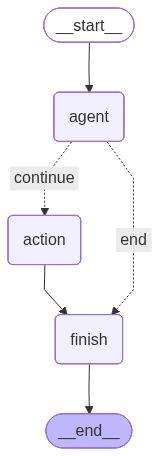

In [13]:
graph

In [14]:
result = await graph.ainvoke(
    {
        "command": "Create a client with this information. Name: Kien, email: test@abc.com.",
        "object_id": "is generated after creation.",
    }
)

Finish with message: INSERT INTO client (name, email, phone) VALUES (Kien, test@abc.com, None)


Trace(trace_id=tr-d6499db6b2bb7b055c91b85a71dcd6e8)

In [15]:
result = await graph.ainvoke(
    {
        "command": "Update the customer's phone number to 555-1234 and email abc@test.com.",
        "object_id": "client_123",
    }
)

Finish with message: UPDATE client SET email = abc@test.com, phone = 555-1234 WHERE client_id = client_123


Trace(trace_id=tr-be4a0a1602faf84ca7df9f0c0d6c66d3)

In [16]:
result

{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 937, 'total_tokens': 966, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-Cc2w9b7wddeRnYBF7gUdsZhyUbLCp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--46f645bd-62d3-432e-89c3-a517b43466a3-0', tool_calls=[{'name': 'update_client', 'args': {'id': 'client_123', 'phone': '555-1234', 'email': 'abc@test.com'}, 'id': 'call_VTHkv9FTljhKhSdwzvIdWoys', 'type': 'tool_call'}], usage_metadata={'input_tokens': 937, 'output_tokens': 29, 'total_tokens': 966, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

In [17]:
result = await graph.ainvoke(
    {
        "command": "Create a job for client id client_123. The job's location is Hanoi, from November 14th to November 20th.",
        "object_id": "is created after creation."
    }
)

Finish with message: INSERT INTO job (client_id, title, description, location, status, start_date, end_date)VALUES (client_123, None, None, Hanoi, None, 2023-11-14 00:00:00, 2023-11-20 00:00:00)


Trace(trace_id=tr-d4eba7f2d9dd5de05287020b0059f400)

In [18]:
result = await graph.ainvoke(
    {
        "command": "Update the job's location to Paris, from November 15th to November 20th.",
        "object_id": "job_456"
    }
)

Finish with message: UPDATE job SET (location=Paris, start_date=2023-11-15 00:00:00+00:00, end_date=2023-11-20 00:00:00+00:00) WHERE job_id = job_456


Trace(trace_id=tr-9eca6e78f66e5a9c7e4c9be79e976557)

In [19]:
result = await graph.ainvoke(
    {
        "command": "What is the weather like?",
        "object_id": "job_456"
    }
)

Finish with message: I don't know.


Trace(trace_id=tr-75ee325fcfbaf9815a6098f08d57de33)